<a href="https://colab.research.google.com/github/fhibs23/Blingual_Back/blob/main/%D0%A1%D0%B5%D0%BC%D0%B0%D0%BD%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%81%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключим все библиотеки

In [66]:
# работа с файлами
import os

# обработка и рисование изображений
import imageio
from PIL import Image

# рисование графиков
import matplotlib.pyplot as plt

import numpy as np # для работы с массивами

# для создание модели
import tensorflow as tf
# Слои, которые потребуются
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose # транспонированная свертка
from tensorflow.keras.layers import concatenate # объединение тензоров

from tensorflow.keras.losses import binary_crossentropy # функция ошибки
from sklearn.model_selection import train_test_split # разделение данных на обучающее и проверочное множества

### загрузка и предобработка данных
- маски хранятся как файлы png, изображения как jpg, названия одинаковые.
- в файлах есть мусор не нужный нам, а именно, файлы mat, файлы png с названиями начинающимися на ".", их выбросим.
- по-хорошему надо сортировать по имени файлы изображений и масок, чтобы соответствовали друг-другу.

In [67]:
# Загрузка данных
def LoadData (path1, path2):
    """
    Принимает пути к директориям с 1-изображениями и 2-масками
    Возвращает два списка: пути к файлам изображения и масок
    """
    # читаем все файлы директории
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # делаем список файлов
    orig_img = []
    mask_img = []
    for file in image_dataset:
      if file[-4:]!='.mat': # пропускаем мусорные файлы
        orig_img.append(file)
    for file in mask_dataset:
      if file[0]!='.': # пропускаем мусорные файлы
        mask_img.append(file)

    # Сортируем по имени
    orig_img.sort()
    mask_img.sort()

    return orig_img, mask_img

Предобработка.

In [134]:
# предобработка данных
def PreprocessData(img, # изображения
                   mask, # маски
                   target_shape_img, # требуемый размер изображения
                   target_shape_mask,#  требуемый размер маски
                   path1, # директория с изображениями
                   path2): # директория с масками
    """
    Изображения трехканальные. Маски одноканальные.
    """
    # требуемые размеры
    m = len(img)                     # число примеров
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask

    # Массивы для изображений и масок, измерение 0 - примеры.
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32) # изображения как числа с плавающей точкой
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.float32) # маски (они же классы) целые числа.

    # Изменяем размеры
    for file in img:
        # Обработка изображений (3 канала)
        index = img.index(file) # индекс в массиве
        path = os.path.join(path1, file) # путь к файлу изображения
        single_img = Image.open(path).convert('RGB') # открываем и конвертируем в RGB
        single_img = single_img.resize((i_h,i_w)) # изменяем размер
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) # нужные размеры массива
        single_img = single_img/255. # приводим диапазон значений пикселей к 0...1 в float32
        X[index] = single_img
        # Обработка масок (3 канал)
        #index = mask.index(file) # индекс в массиве
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind) # путь к файлу маски
        single_mask = Image.open(path).convert('RGB') # открываем, конвертировать не надо, оно и так бинарное
        single_mask = single_mask.resize((m_h, m_w)) # изменяем размер
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c))  # нужные размеры массива
        single_mask = single_mask/255. # приводим диапазон значений пикселей к 0...1 в float32
        y[index] = single_mask
    return X, y

## Создаем UNet


### Блок кодера

Блок кодера понижает пространственные размеры в два раза. Состоит из слоев сверток и субдискретизации, использует слои dropout и BatchNormalization. Активация relu.

In [117]:
# Блок кодера
def EncoderMiniBlock(inputs, # вход
                     n_filters=32, # количество фильтров
                     dropout_prob=0.3, # вероятность отброса
                     max_pooling=True): # использовать ли субдискретизацию

    # Два сверточных слоя (выходы) с инициализацией.
    # Набивка 'Same' не изменяет пространственные размеры.
    conv = Conv2D(n_filters,
                  3,   # размер ядра
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs) # инициализация (только при создании)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Нормализация
    conv = BatchNormalization()(conv, training=False)

    # dropout, если задан
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Субдискретизация, если задано. Конкретно MaxPooling, уменьшает пространственные размеры в два раза
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # выход слоев ДО субдискретизации, будет передаваться в другие блоки.
    skip_connection = conv

    return next_layer, skip_connection # возвращаем выход блока и выход слоев до субдискретизации

### Блок декодера.
Принимает выход предыдущего слоя и выход заданного блока кодера.

- Увеличивает в два раза пространственные размеры выхода предыдущего слоя за счет транспонированной свертки.
- Конкатенирует результат с полученным выходом блока кодера.
- Применяет два сверточных слоя не изменяющих пространственные размеры.


In [118]:
# Блок декодера
def DecoderMiniBlock(prev_layer_input, # выход предыдущего слоя (блока)
                     skip_layer_input, # выход соответствующего блока кодера
                     n_filters=32): # число фильтров

    # Транспонированная свертка увеличивает пространственный размер карты признаков в два раза
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # размер ядра
                 strides=(2,2), # увеличение размера (обратите внимание для транспонированной свертки это увеличивает размер)
                 padding='same')(prev_layer_input) # набивка, чтобы не уменьшался размер при выполнении свертки

    # Конкатенируем по каналам (измерение 3) выход транспонированной свертки и выход блока кодера
    merge = concatenate([up, skip_layer_input], axis=3)

    # Две свертки не изменяющие размеры, с инициализацией
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

### Собираем UNet
Сеть UNet состоит из:

- 4 блоков кодера с понижением размеров карт признаков, но увеличением числа каналов.
- одного блока кодера без понижения размера.
- 4 блоков декодера с повышением размера карт признаков и понижением числа каналов.
- сверточного слоя не изменяющего размеры.
- выходного сверточного слоя с числом фильтров по количеству классов.





In [119]:
def UNetCompiled(input_size=(128, 128, 3), # размер изображения-входа
                 n_filters=32, # базовое число фильтров
                 n_classes=3): # число классов

    # Вход в сеть заданного размера
    inputs = Input(input_size)

    # Кодер
    # блок 1 принимает вход в сеть, число фильтров базовое, dropout нет, понижает размеры карты
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    # блок 2 принимает выход блока 1 (обратите внимание что блоки кодера возвращают два выхода),
    # число фильтров в два раза больше, dropout нет, понижает размеры карты
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    # блок 3 принимает выход блока 2, число фильтров еще в два раза больше, dropout нет, понижает размеры карты
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    # блок 4 принимает выход блока 3, число фильтров еще в два раза больше, dropout есть, понижает размеры карты
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    # блок 5 принимает выход блока 4, число фильтров еще в два раза больше, dropout есть, НЕ понижает размеры карты
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Декодер
    # блок 6 принимает выход блока 5, и второй выход (т.е. до слоя субдискретизации) блока 4,
    # число фильтров в два раза меньше чем у блока 5, повышает размеры карты
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    # блок 7 принимает выход блока 6, и второй выход блока 3, число фильтров в два раза меньше, повышает размеры карты
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    # блок 8 принимает выход блока 7, и второй выход блока 2, число фильтров в два раза меньше, повышает размеры карты
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    # блок 9 принимает выход блока 8, и второй выход блока 1, число фильтров в два раза меньше, повышает размеры карты
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # слой свертки без изменения размеров карты, число фильтров как у предыдущего блока
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    # слой свертки без изменения размеров карты, число фильтров по количеству классов
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Создаем модель из слоев
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

## Эксперименты

Скачиваем и загружаем данные.

In [ ]:
# !pip install gdown
#import gdown
# изображения
#url = 'https://drive.google.com/uc?export=download&confirm=y&id=1Jc87BajpCwg1zkbc2hi-PPlHu7QhTo-W'
#output = './images'
#gdown.download(url, output, quiet=False)

In [1]:
# маски
#url = 'https://github.com/fhibs23/vkr/tree/main/mask'
#output = './masks'
#gdown.download(url, output, quiet=False)
!git clone https://github.com/fhibs23/vkr.git

Cloning into 'vkr'...
remote: Enumerating objects: 3422, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 3422 (delta 2), reused 105 (delta 2), pack-reused 3317
Receiving objects: 100% (3422/3422), 205.34 MiB | 24.34 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [9]:
# загружаем
path1 = '/content/vkr/train/'
path2 = '/content/vkr/mask/'
img, mask = LoadData (path1, path2)


Посмотрим на некоторые данные.

<ipython-input-72-f05823d2da23>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_view  = imageio.imread(path1 + img[i]) # путь к изображению
<ipython-input-72-f05823d2da23>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask_view = imageio.imread(path2 + mask[i]) # путь к его маске


(316, 320)
(316, 320)
(316, 320)
(316, 320)


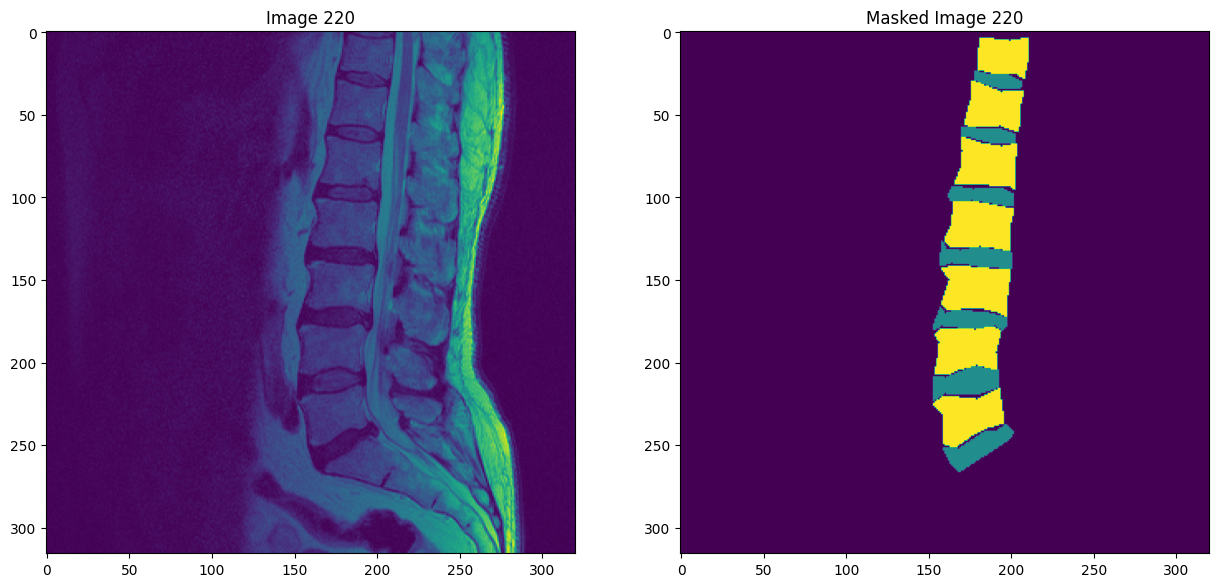

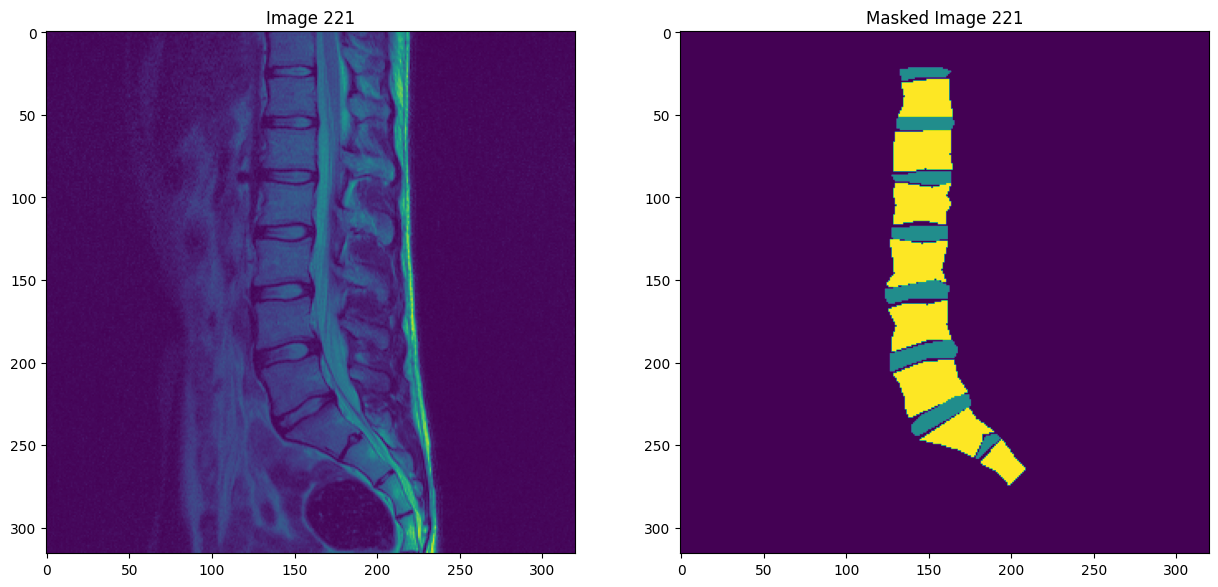

In [72]:

# рисуем изображения и маски
start_img = 220 #
stop_img = 222
for i in range(start_img, stop_img):

    img_view  = imageio.imread(path1 + img[i]) # путь к изображению
    mask_view = imageio.imread(path2 + mask[i]) # путь к его маске

    print(img_view.shape)
    print(mask_view.shape)
    #print(mask_view.min(), mask_view.max())
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view) # рисуем изображение
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view) # рисуем маску
    arr[1].set_title('Masked Image '+ str(i))

Предобработка

X Shape: (263, 128, 128, 3)
Y shape: (263, 128, 128, 3)
[0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.329411

Text(0.5, 1.0, 'Processed Masked Image ')

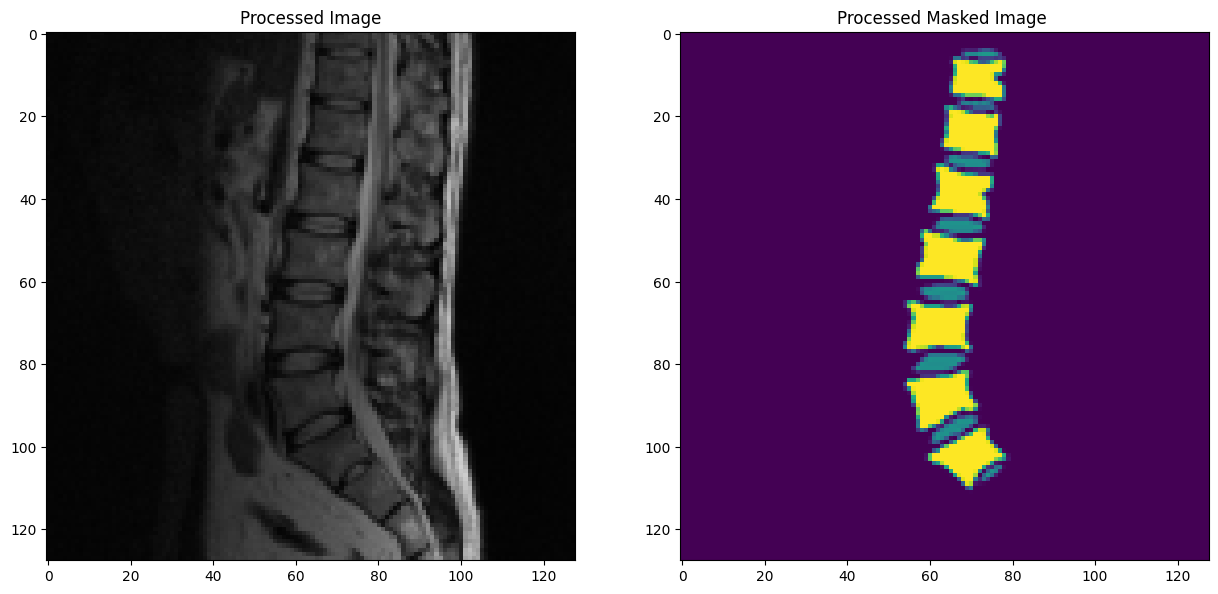

In [135]:
target_shape_img = [128, 128, 3] # размер изображений
target_shape_mask = [128, 128, 3] # размер масок

# обрабатываем
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

#
print("X Shape:", X.shape)
print("Y shape:", y.shape)
# Классы : фон, позвонки, диски
print(np.unique(y))

# отображаем обработанные изображения и маски
image_index = 100
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

Разделяем данные на обучающие 80% и проверочные 20% случайно.

In [110]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

Создаем сеть, 3 класса, 32 базовых каналов.

In [111]:

unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [76]:
# посмотрим на сеть
unet.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_80 (Conv2D)             (None, 128, 128, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_81 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_80[0][0]']              
                                )                                                           

Задаем параметры обучения и обучаем сеть.

In [123]:
# оптимизатор Adam, функция ошибки - кроссэнтропия которая применяет softmax к выходам сети, метрика - аккуратность

unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [136]:
# Обучаем ~ 10 минут (увеличьте число эпох)
results = unet.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10


InvalidArgumentError: ignored

### Проверяем работу модели

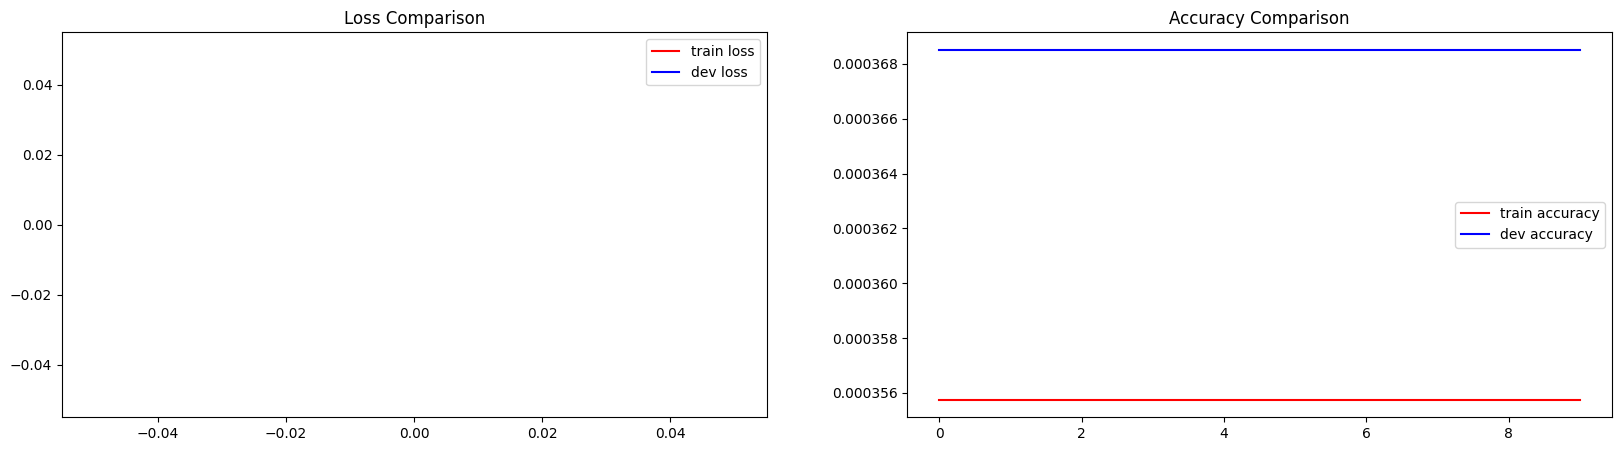

In [48]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()


Строим и сравниваем маски для проверочных данных

In [49]:
# оценка качества сети
unet.evaluate(X_valid, y_valid)

2/2 [==============================] - 0s 69ms/step - loss: nan - accuracy: 3.6851e-04


[nan, 0.000368514156434685]

In [50]:
# рисуем
def VisualizeResults(index):
    img = X_valid[index] # изображение
    img = img[np.newaxis, ...] # добавляем измерение примеров
    pred_y = unet.predict(img) # расчитываем маску
    pred_mask = tf.argmax(pred_y[0], axis=-1) # выбираем максимальный класс (канал - последнее измерение)
    pred_mask = pred_mask[..., tf.newaxis] # канальное измерение добавляем
    # рисуем
    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

1/1 [==============================] - 0s 35ms/step


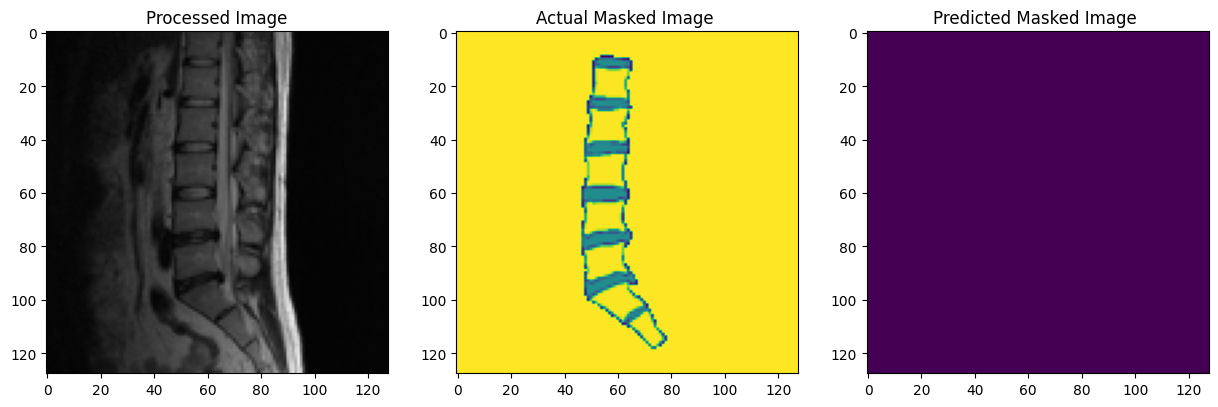

In [51]:
# рисуем
index = 52
VisualizeResults(index)

# Ссылки

Использованы и адаптированы материалы:

- https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406
- https://colab.research.google.com/github/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb
- https://www.tensorflow.org/tutorials/images/segmentation

